**CPE-4102**

**NAME:** ATIENZA, KURT CYDRICK A.

**SR-CODE:** 21-00415

**NAME:** ROBLES, DANIELLA L.

**SR-CODE:** 21-03577

I. DATA COLLECTION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


II. PREPARATION & DATA PREPROCESSING

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os

# Constants
IMAGE_SIZE = (224, 224)  # Required for ResNet input
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 3  # For Coke, Sprite, Mountain Dew

TRAIN_DIR = '/content/drive/MyDrive/SoftdrinksDataset/train'
VALID_DIR = '/content/drive/MyDrive/SoftdrinksDataset/valid'
TEST_DIR = '/content/drive/MyDrive/SoftdrinksDataset/test'

In [ ]:
# Data Generators with Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 105 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


III. CNN MODEL

In [ ]:
#CNN MODEL (Using ResNet50)
def build_resnet_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_resnet_model()

IV. COMPILATION AND TRAINING OF THE MODEL

In [ ]:
# --- COMPILATION AND TRAINING OF THE MODEL ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)  # Changed extension to .keras

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.3331 - loss: 1.4073 - precision_2: 0.3112 - recall_2: 0.2345 - val_accuracy: 0.7333 - val_loss: 0.9807 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.3830 - loss: 1.1128 - precision_2: 0.4734 - recall_2: 0.2115 - val_accuracy: 0.6667 - val_loss: 0.9335 - val_precision_2: 1.0000 - val_recall_2: 0.1000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.4722 - loss: 1.0515 - precision_2: 0.5263 - recall_2: 0.2880 - val_accuracy: 0.6667 - val_loss: 0.8993 - val_precision_2: 1.0000 - val_recall_2: 0.3333
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step - accuracy: 0.4690 - loss: 1.0564 - precision_2: 0.5725 - recall_2: 0.3585 - val_accuracy: 0.6667 - val_loss: 0.8594 - val_precision_2: 1.0000 - val_recall_2: 0.3333
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.4787 - loss: 1.1081 - precision_2: 0.5103 - recall_2: 0.3060 - val_accuracy: 0.6667 -

V. EVALUATION

In [ ]:
# Load the best model
model.load_weights('best_model.keras')
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.7068 - precision_2: 1.0000 - recall_2: 0.3333
Test Accuracy: 1.0000
Precision: 1.0000
Recall: 0.3333
F1 Score: 0.5000


In [ ]:
# --- Evaluating Model Performance with Metrics (Precision, Recall, F1 Score) ---
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

precision = Precision()(y_true, y_pred).numpy()
recall = Recall()(y_true, y_pred).numpy()
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


-VISUALIZATION

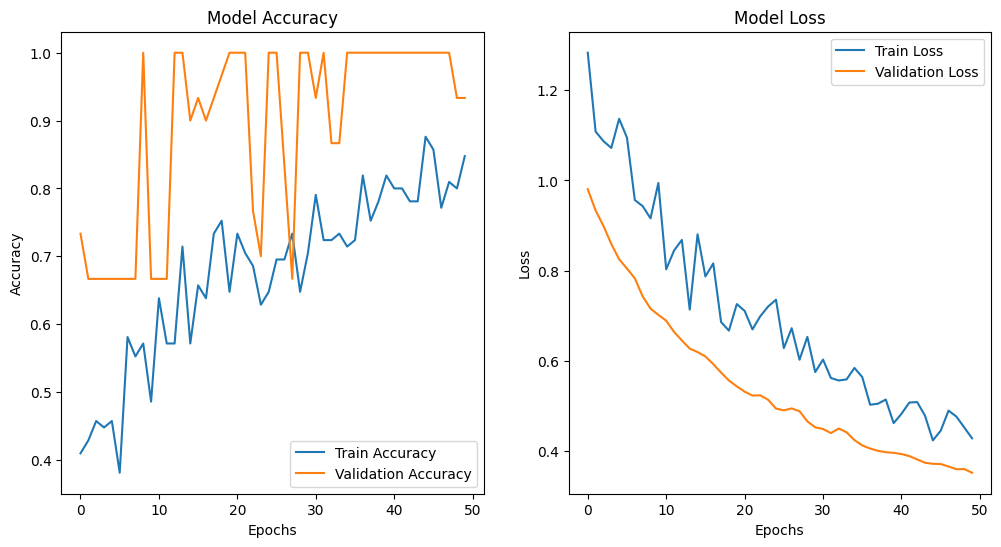

In [ ]:
# Plot Accuracy and Loss over Epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

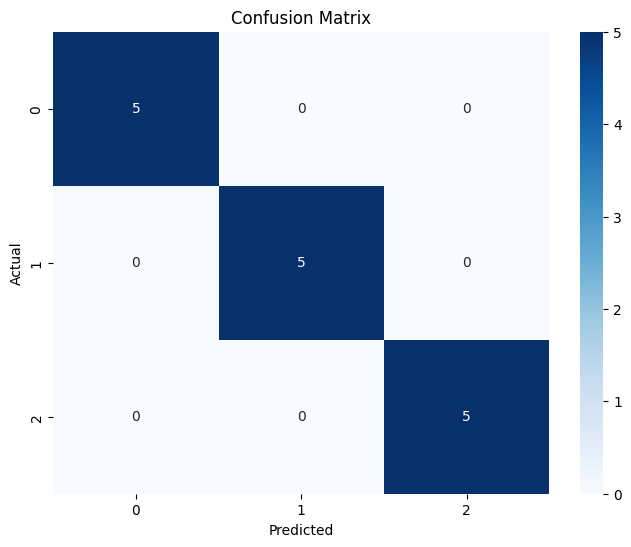

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your true labels (y_true) and predicted labels (y_pred)
# Replace with your actual data

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

-Testing the Model on New Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


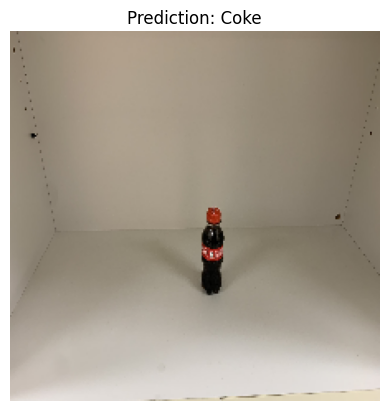

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


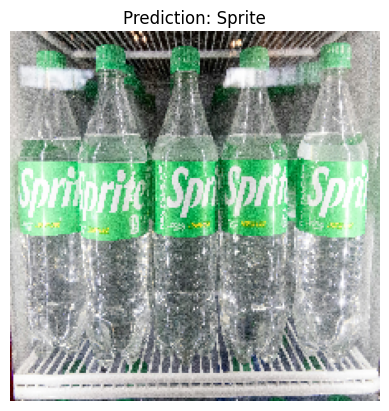

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


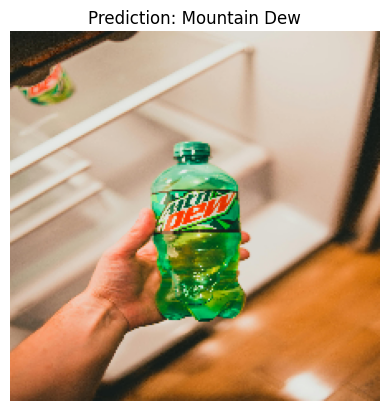

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Add this import

# Define a function for loading and predicting on a new image
def predict_new_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)  # Load and resize the image
    img_array = img_to_array(img) / 255.0               # Convert image to array and normalize
    img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_names = ['Coke', 'Sprite', 'Mountain Dew']    # Update these to match your class labels
    predicted_label = class_names[predicted_class]

    # Display image and prediction
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis('off')
    plt.show()

# Test on new images
new_image_paths = [
    '/content/IMG_3737.JPEG',
    '/content/mick-haupt-opPjYeX5FDc-unsplash.jpg',
    '/content/pexels-introspectivedsgn-9395977.jpg'
]

for image_path in new_image_paths:
    predict_new_image(image_path)
